In [1]:
import pandas as pd
import numpy as np
import gc
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import MinMaxScaler


from myutils import reduce_mem_usage

lentrain = 1503424
lentest = 508438
lentrainactive = 14129821
lentestactive = 12824068

categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
dropcols = ['Weekday']

In [2]:
def scale_standard(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        #print(col)
        if (str(df[col].dtype)[:5] == 'float') and (not col in ignorecol):
            temp = SS().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def get_smalldiff(df1, df2, userate=0.2):
    assert (df1.columns == df2.columns).all(), 'inputs must have same columns'
    th = np.uint(df1.shape[1] * userate)
    criteria = {'mean': np.mean, 'var': np.var, 'median': np.median}
    difflist = []
    tempdiff = pd.DataFrame()
    tempdiff['colname'] = [col for col in df1.columns]
    for k, c in criteria.items():
        tempdiff[k] = [np.abs(c(df1[col]) - c(df2[col])) for col in df1.columns]
    tempdiff = scale_standard(tempdiff, ignorecol=['colname'])
    sums = np.zeros(tempdiff.shape[0])
    for key in criteria.keys():
        sums += np.abs(tempdiff[key])
    tempdiff['result'] = sums
    sortdiff = tempdiff.sort_values(by='result')
    print(sortdiff[['colname', 'result']])
    return sortdiff['colname'][: th].tolist()

def loadfeather(trpath, tepath, reader=pd.read_feather):
    train = reader(trpath)
    test = reader(tepath)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)    
    df = pd.concat([train, test])
    del train, test; gc.collect()
    print(df.nunique())
    return df

def plothist(df):
    sidesplit = 3
    versplit = len(df.columns)//sidesplit + 1
    width = 4*sidesplit
    height = 3*versplit
    plt.figure(figsize=(width, height))
    for i, col in enumerate(df.columns):
        plt.subplot(versplit, sidesplit, i+1)
        plt.hist(df.iloc[:, i], label=col) 
        plt.legend()
    plt.show()

def plotcorr(df):
    colsize = len(df.columns)
    width = 6 + np.uint(colsize*0.2)
    height = 4 + np.uint(colsize*0.2)
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.set(style='white')
    f, ax = plt.subplots(figsize=(width, height))
    cmap = sns.diverging_palette(30, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
def concat2master(df, dfmaster):
    print(df.shape)
    #print(df.isnull().sum())
    df = reduce_mem_usage(df)
    #print(df.columns)
    #print(df.dtypes)
    for col in df.columns:
        dfmaster[col] = df[col]
    del df; gc.collect()
    print(dfmaster.shape)
    print(dfmaster.memory_usage().sum() / 1024**2, ' MB')
    return dfmaster

def scale_minmax(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        if (str(df[col].dtype)[:3] == 'int') or (str(df[col].dtype)[:4] == 'uint'):
            print(col)
            temp = MinMaxScaler().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def choose_unique(df):
    print(f'before: {len(df.columns)}')
    uniques = {col: df[col].nunique() for col in df.columns}
    uniques_list = []
    for val in set(uniques.values()):
        temp = [k for k, v in uniques.items() if v == val]
        uniques_list.append(temp)
    uniques_list
    choiced = [str(np.random.choice(l, 1)[0]) for l in uniques_list]
    print(f'after: {len(choiced)}')
    return choiced

In [3]:
dfmaster = pd.DataFrame()

user_id                         1009909
region                               28
city                               1752
parent_category_name                  9
category_name                        47
param_1                             372
param_2                             278
param_3                            1277
price                             20761
item_seq_number                   33947
user_type                             3
image_top_1                        3064
Weekday                               7
desc_punc                           739
description_num_words               558
description_num_unique_words        353
description_words_vs_unique       12341
title_num_words                      17
title_num_unique_words               15
title_words_vs_unique                36
ridge_preds                     1954410
dtype: int64
user_id 1009909
region 28
city 1752
parent_category_name 9
category_name 47
user_type 3
image_top_1 3064
param_1 372
param_2 278
param_3 1277


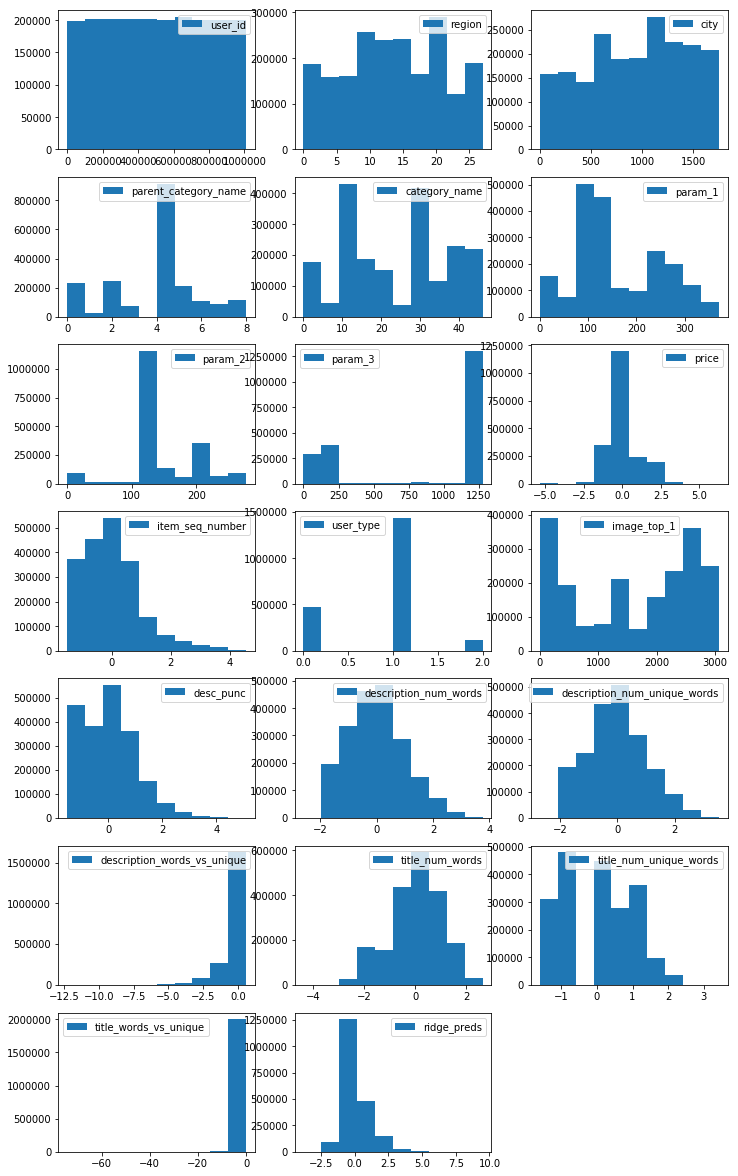

(2011862, 20)
Memory usage of dataframe is 322.34 MB
Memory usage after optimization is: 126.63 MB
Decreased by 60.7%
(2011862, 20)
126.63163375854492  MB


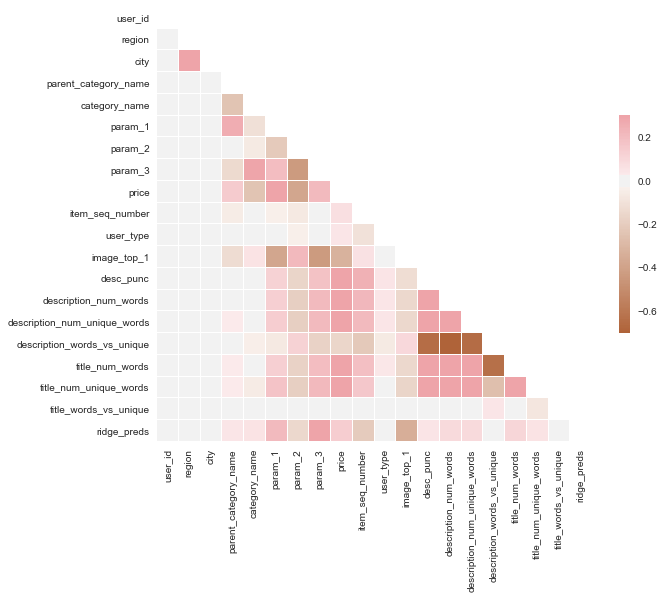

In [4]:
df = loadfeather('./kernel_train.feather', './kernel_test.feather')
for col in categorical:
    print(col, str(df[col].nunique()))
df['desc_punc'] = np.log1p(df['desc_punc'])
df['description_num_words'] = np.log1p(df['description_num_words'])
df['description_num_unique_words'] = np.log1p(df['description_num_unique_words'])
df['title_num_words'] = np.log1p(df['description_num_words'])
df['title_num_unique_words'] = np.log1p(df['title_num_unique_words'])
df['description_words_vs_unique'].fillna(df['description_words_vs_unique'].mean(), inplace=True)
df['item_seq_number'] = np.log1p(df['item_seq_number'])

df.drop(dropcols, axis=1, inplace=True)
df = scale_standard(df, ignorecol=categorical)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

avg_days_up_user         17413
avg_times_up_user         7204
avg_headdays_up_user     29551
n_user_items               956
avg_price_up_user       161337
var_price_up_user       309985
dtype: int64


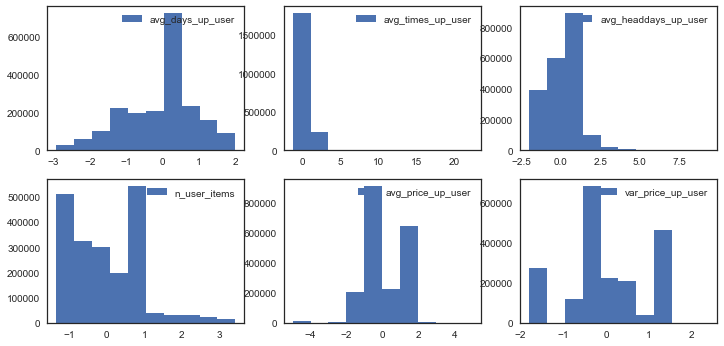

                colname    result
4     avg_price_up_user  2.157388
3          n_user_items  2.369647
1     avg_times_up_user  2.633943
0      avg_days_up_user  2.708459
5     var_price_up_user  2.797616
2  avg_headdays_up_user  4.140698
(2011862, 6)
Memory usage of dataframe is 61.40 MB
Memory usage after optimization is: 61.40 MB
Decreased by 0.0%
(2011862, 26)
172.67950057983398  MB


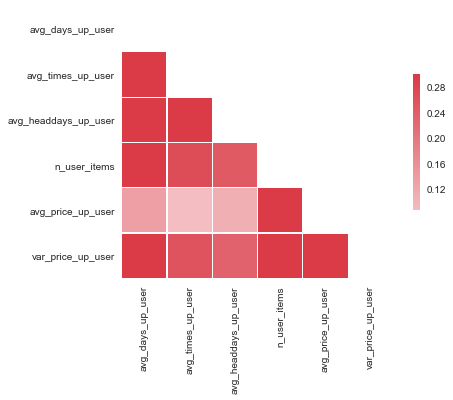

In [5]:
# User Data Agg
df = loadfeather('../features/train/Agg_User_train.feather', '../features/test/Agg_User_test.feather')
df['n_user_items'] = np.log1p(df['n_user_items'])
df['avg_price_up_user'] = np.log(df['avg_price_up_user']+0.001)
df['var_price_up_user'] = np.log(df['var_price_up_user']+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)


In [6]:
# Count Agg
'''
df = loadfeather('../features/train/Agg_Count_Silver_train.feather', '../features/test/Agg_Count_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Count_Silver_train.feather', '../features/test/Agg_Count_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [7]:
# Agg Price Silver Mean
'''
df = loadfeather('../features/train/Agg_Price_mean_Silver_train.feather', '../features/test/Agg_Price_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_mean_Silver_train.feather', '../features/test/Agg_Price_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [8]:
# Agg Price Silver Var
'''
df = loadfeather('../features/train/Agg_Price_var_Silver_train.feather', '../features/test/Agg_Price_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_var_Silver_train.feather', '../features/test/Agg_Price_var_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [9]:
# Agg Price Silver Median
'''
df = loadfeather('../features/train/Agg_Price_median_Silver_train.feather', '../features/test/Agg_Price_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Price_median_Silver_train.feather', '../features/test/Agg_Price_median_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [10]:
# Agg Item Silver mean
'''
df = loadfeather('../features/train/Agg_Itemseq_mean_Silver_train.feather', '../features/test/Agg_Itemseq_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_mean_Silver_train.feather', '../features/test/Agg_Itemseq_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [11]:
# Agg Itemseq Silver Var
'''
df = loadfeather('../features/train/Agg_Itemseq_var_Silver_train.feather', '../features/test/Agg_Itemseq_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_var_Silver_train.feather', '../features/test/Agg_Itemseq_var_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [12]:
# Agg Itemseq Silver Median
'''
df = loadfeather('../features/train/Agg_Itemseq_median_Silver_train.feather', '../features/test/Agg_Itemseq_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Itemseq_median_Silver_train.feather', '../features/test/Agg_Itemseq_median_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [13]:
# Agg Nunique Silver
'''
df = loadfeather('../features/train/Agg_Unique_Silver_train.feather', '../features/test/Agg_Unique_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Unique_Silver_train.feather', '../features/test/Agg_Unique_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [14]:
# Agg Imagetop Mean
'''
df = loadfeather('../features/train/Agg_Imagetop1_mean_Silver_train.feather', '../features/test/Agg_Imagetop1_mean_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_mean_Silver_train.feather', '../features/test/Agg_Imagetop1_mean_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [15]:
# Agg Imagetop Var
'''
df = loadfeather('../features/train/Agg_Imagetop1_var_Silver_train.feather', '../features/test/Agg_Imagetop1_var_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_var_Silver_train.feather', '../features/test/Agg_Imagetop1_var_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

In [16]:
# Agg Imagetop Median
'''
df = loadfeather('../features/train/Agg_Imagetop1_median_Silver_train.feather', '../features/test/Agg_Imagetop1_median_Silver_test.feather')
usecol = choose_unique(df)
df = df[usecol]
plothist(df)
plotcorr(df)
_ = get_smalldiff(df[:lentrain], df[lentrain:])
dfmaster = concat2master(df, dfmaster)
'''

"\ndf = loadfeather('../features/train/Agg_Imagetop1_median_Silver_train.feather', '../features/test/Agg_Imagetop1_median_Silver_test.feather')\nusecol = choose_unique(df)\ndf = df[usecol]\nplothist(df)\nplotcorr(df)\n_ = get_smalldiff(df[:lentrain], df[lentrain:])\ndfmaster = concat2master(df, dfmaster)\n"

imagefeatures__dullness                 20000
imagefeatures__whiteness                19999
imagefeatures__average_pixel_width     385129
imagefeatures__image_size               91662
imagefeatures__blurrness              1800693
imagefeatures__average_red            1728771
imagefeatures__average_green          1707081
imagefeatures__average_blue           1702035
imagefeatures__width                      609
imagefeatures__height                     452
dtype: int64
imagefeatures__image_size
imagefeatures__width
imagefeatures__height


C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ahega\Anaconda3\envs\Avito18_Kaggle\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


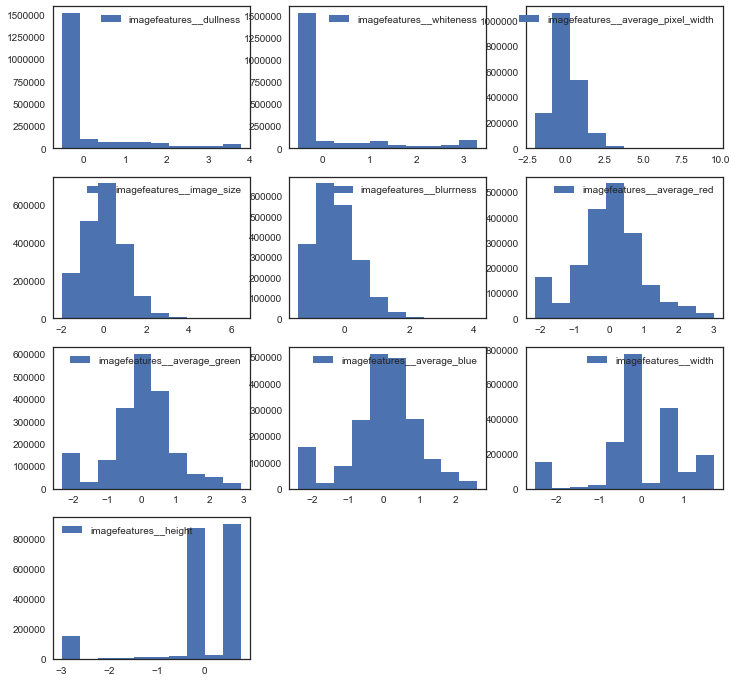

(2011862, 10)
Memory usage of dataframe is 115.12 MB
Memory usage after optimization is: 92.10 MB
Decreased by 20.0%
(2011862, 36)
249.42594528198242  MB


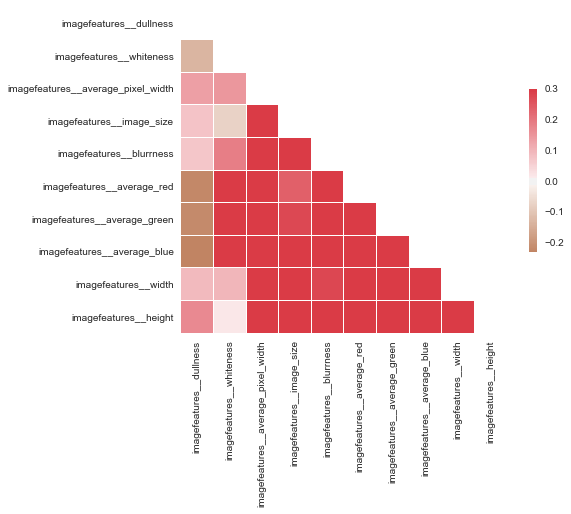

In [17]:
# Image Features
df = loadfeather('../features/train/imagefeatures_train.feather', '../features/test/imagefeatures_test.feather')
df = scale_minmax(df)
df = scale_standard(df)
df['imagefeatures__blurrness'] = np.log1p(df['imagefeatures__blurrness'])
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

imagenet_Resnet50_top1    1737109
imagenet_Resnet50_top2    1790338
imagenet_Resnet50_top3    1793828
dtype: int64


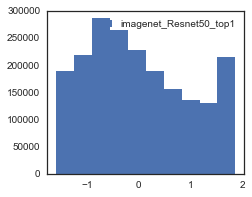

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 37)
257.10058975219727  MB
imagenet_IndeptionV3_top1     579634
imagenet_IndeptionV3_top2    1725460
imagenet_IndeptionV3_top3    1728988
dtype: int64


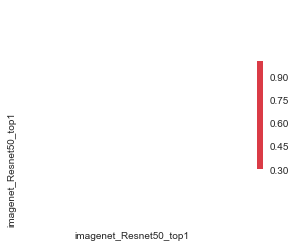

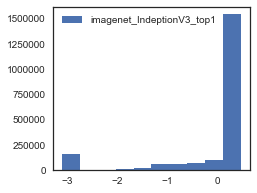

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 38)
264.7752342224121  MB
imagenet_Xception_top1    1085618
imagenet_Xception_top2    1823811
imagenet_Xception_top3    1828911
dtype: int64


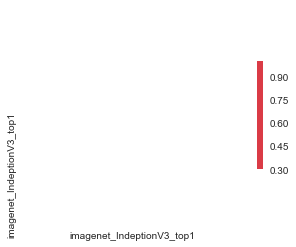

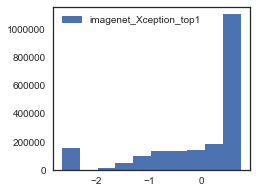

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 39)
272.44987869262695  MB
imagenet_Movilenet_top1    1767470
imagenet_Movilenet_top2    1765864
imagenet_Movilenet_top3    1757845
dtype: int64


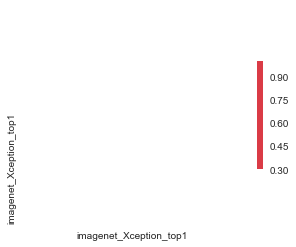

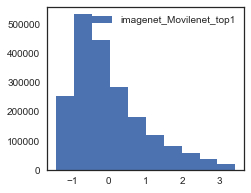

(2011862, 1)
Memory usage of dataframe is 30.70 MB
Memory usage after optimization is: 23.02 MB
Decreased by 25.0%
(2011862, 40)
280.1245231628418  MB


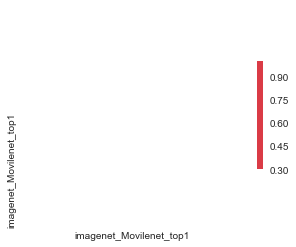

In [18]:
# imagenet
# Resnet50
df = loadfeather('../features/train/imagenet_Resnet50_train.feather', '../features/test/imagenet_Resnet50_test_debug.feather')
usecol = ['imagenet_Resnet50_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Inception V3
df = loadfeather('../features/train/imagenet_IndeptionV3_train.feather', '../features/test/imagenet_IndeptionV3_test_debug.feather')
usecol = ['imagenet_IndeptionV3_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Xception
df = loadfeather('../features/train/imagenet_Xception_train.feather', '../features/test/imagenet_Xception_test_debug.feather')
usecol = ['imagenet_Xception_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

# Mobilenet
df = loadfeather('../features/train/imagenet_Movilenet_train_debug.feather', '../features/test/imagenet_Movilenet_test_debug.feather')
usecol = ['imagenet_Movilenet_top1']
df = df[usecol]
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

In [19]:
# Create fulldata

train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_full_4.feather')
test.to_feather('../features/featured/test_full_4.feather')

del train, test; gc.collect()
categorical


(1503424, 40)
(508438, 40)


['user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'user_type',
 'image_top_1',
 'param_1',
 'param_2',
 'param_3']

In [20]:
# Create Reduced data
'''
train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

res = get_smalldiff(train, test, userate=0.6)
train = train[res]
test = test[res]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_reduced.feather')
test.to_feather('../features/featured/test_reduced.feather')

categorical_ex1 = [col for col in train.columns if col in categorical]
del train, test; gc.collect()
categorical_ex1
'''


"\ntrain = dfmaster[:lentrain]\ntest = dfmaster[lentrain: lentrain+lentest]\n\nres = get_smalldiff(train, test, userate=0.6)\ntrain = train[res]\ntest = test[res]\n\nprint(train.shape)\nprint(test.shape)\n\ntrain.to_feather('../features/featured/train_reduced.feather')\ntest.to_feather('../features/featured/test_reduced.feather')\n\ncategorical_ex1 = [col for col in train.columns if col in categorical]\ndel train, test; gc.collect()\ncategorical_ex1\n"

In [21]:
# Create Reduced data
'''
train = dfmaster[:lentrain]
test = dfmaster[lentrain: lentrain+lentest]

res = get_smalldiff(train, test, userate=0.3)
train = train[res]
test = test[res]

print(train.shape)
print(test.shape)

train.to_feather('../features/featured/train_reduced_more.feather')
test.to_feather('../features/featured/test_reduced_more.feather')

categorical_ex2 = [col for col in train.columns if col in categorical]
del train, test; gc.collect()
categorical_ex2
'''


"\ntrain = dfmaster[:lentrain]\ntest = dfmaster[lentrain: lentrain+lentest]\n\nres = get_smalldiff(train, test, userate=0.3)\ntrain = train[res]\ntest = test[res]\n\nprint(train.shape)\nprint(test.shape)\n\ntrain.to_feather('../features/featured/train_reduced_more.feather')\ntest.to_feather('../features/featured/test_reduced_more.feather')\n\ncategorical_ex2 = [col for col in train.columns if col in categorical]\ndel train, test; gc.collect()\ncategorical_ex2\n"

In [22]:
dfmaster.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,...,imagefeatures__blurrness,imagefeatures__average_red,imagefeatures__average_green,imagefeatures__average_blue,imagefeatures__width,imagefeatures__height,imagenet_Resnet50_top1,imagenet_IndeptionV3_top1,imagenet_Xception_top1,imagenet_Movilenet_top1
0,884270,19,462,4,42,249,112,1217,-0.677024,-1.297002,...,-0.432018,-0.278210,-0.634123,0.686001,-0.150559,0.758586,-1.593788,-3.098809,-2.640898,0.408558
1,227908,17,1314,2,22,122,112,1217,0.053957,-0.300643,...,0.243387,-0.605289,-0.391314,-0.264190,-0.137390,0.758586,-1.168998,0.468036,-0.113284,0.790422
2,576261,16,1290,0,2,84,112,1217,0.158324,-0.664681,...,-0.292642,1.483807,1.375924,1.138331,0.073317,-0.177207,0.385052,0.466027,0.736486,-0.517972
3,755087,21,950,4,42,38,112,1217,-0.058564,1.098347,...,-0.465948,2.247374,2.125277,1.848744,-0.137390,-0.177207,-0.649074,0.468036,0.522710,-0.929891
4,944363,4,318,6,0,278,124,46,0.993673,-1.145913,...,-0.209743,0.176595,0.376505,0.051739,1.706301,-0.177207,0.426342,0.330671,-1.615118,-0.670591
